# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

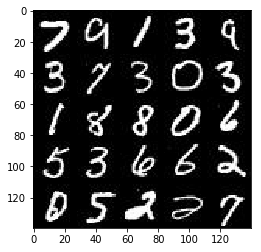

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

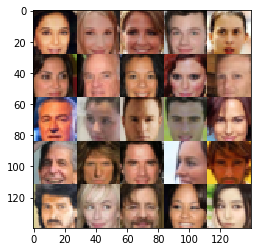

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return (real_input, z_input, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input 28x28x3
        c1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='SAME')
        reul1 = tf.maximum(alpha*c1, c1)
        # 14X14x64
        
        c2 = tf.layers.conv2d(c1, filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME')
        bn2 = tf.layers.batch_normalization(c2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 7x7x128
        
        c3 = tf.layers.conv2d(c2, filters=256, kernel_size=(5,5), strides=(2,2), padding='SAME')
        bn3 = tf.layers.batch_normalization(c3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Project input vector
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape to start convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=(5,5), strides=(2,2), padding='VALID')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='SAME')
        # 28x28x3
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_faked = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_faked, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)
        )
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    n_samples, width, height, channels = data_shape
    input_real, input_z, learning_rate_tf = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_tf, beta1)
    
    current_step = 0
    print_loss_every = 10
    show_image_every = 50
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                current_step +=1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tf:learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tf:learning_rate})
                
                if current_step % print_loss_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if current_step % show_image_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.3620... Generator Loss: 5.8124
Epoch 0/2... Discriminator Loss: 1.9198... Generator Loss: 0.5858
Epoch 0/2... Discriminator Loss: 0.1189... Generator Loss: 4.6416
Epoch 0/2... Discriminator Loss: 0.0436... Generator Loss: 4.1454
Epoch 0/2... Discriminator Loss: 0.0789... Generator Loss: 9.1374


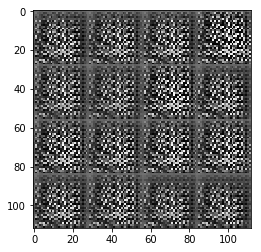

Epoch 0/2... Discriminator Loss: 0.2714... Generator Loss: 2.7488
Epoch 0/2... Discriminator Loss: 0.0290... Generator Loss: 7.8951
Epoch 0/2... Discriminator Loss: 0.1971... Generator Loss: 1.9487
Epoch 0/2... Discriminator Loss: 0.0786... Generator Loss: 12.5389
Epoch 0/2... Discriminator Loss: 0.4123... Generator Loss: 1.3844


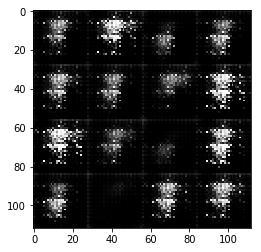

Epoch 0/2... Discriminator Loss: 0.2134... Generator Loss: 2.7172
Epoch 0/2... Discriminator Loss: 0.3429... Generator Loss: 2.3960
Epoch 0/2... Discriminator Loss: 0.1858... Generator Loss: 4.8132
Epoch 0/2... Discriminator Loss: 0.3435... Generator Loss: 9.1263
Epoch 0/2... Discriminator Loss: 0.4308... Generator Loss: 1.3496


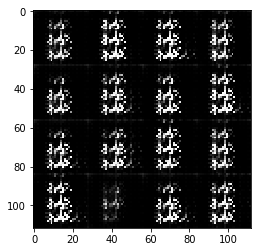

Epoch 0/2... Discriminator Loss: 0.5281... Generator Loss: 3.8798
Epoch 0/2... Discriminator Loss: 0.2048... Generator Loss: 5.7262
Epoch 0/2... Discriminator Loss: 0.3893... Generator Loss: 2.4333
Epoch 0/2... Discriminator Loss: 0.4717... Generator Loss: 3.6568
Epoch 0/2... Discriminator Loss: 1.9936... Generator Loss: 5.8386


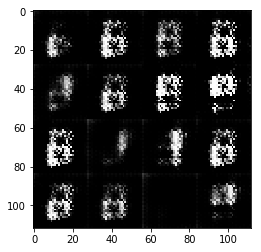

Epoch 0/2... Discriminator Loss: 0.3799... Generator Loss: 2.7555
Epoch 0/2... Discriminator Loss: 0.2766... Generator Loss: 3.7539
Epoch 0/2... Discriminator Loss: 0.4970... Generator Loss: 2.0599
Epoch 0/2... Discriminator Loss: 0.1734... Generator Loss: 3.1108
Epoch 0/2... Discriminator Loss: 0.2723... Generator Loss: 2.1384


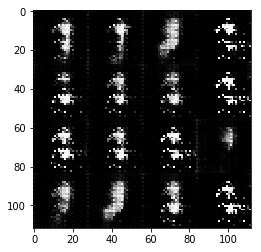

Epoch 0/2... Discriminator Loss: 0.7800... Generator Loss: 3.1520
Epoch 0/2... Discriminator Loss: 0.5126... Generator Loss: 1.4667
Epoch 0/2... Discriminator Loss: 0.8743... Generator Loss: 2.8042
Epoch 0/2... Discriminator Loss: 0.6658... Generator Loss: 1.6496
Epoch 0/2... Discriminator Loss: 1.3923... Generator Loss: 7.0429


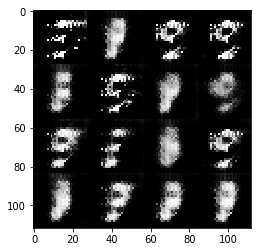

Epoch 0/2... Discriminator Loss: 0.8942... Generator Loss: 1.5073
Epoch 0/2... Discriminator Loss: 0.7371... Generator Loss: 1.3212
Epoch 0/2... Discriminator Loss: 0.6488... Generator Loss: 1.6942
Epoch 0/2... Discriminator Loss: 1.0102... Generator Loss: 1.4846
Epoch 0/2... Discriminator Loss: 0.7302... Generator Loss: 0.9712


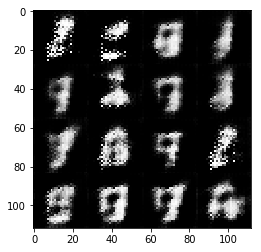

Epoch 0/2... Discriminator Loss: 1.8050... Generator Loss: 3.9216
Epoch 0/2... Discriminator Loss: 0.8281... Generator Loss: 1.4907
Epoch 0/2... Discriminator Loss: 0.5609... Generator Loss: 1.4042
Epoch 0/2... Discriminator Loss: 0.5831... Generator Loss: 2.4632
Epoch 0/2... Discriminator Loss: 0.5033... Generator Loss: 1.8380


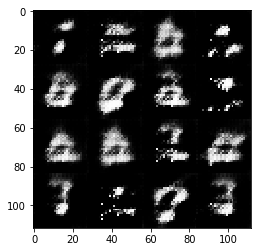

Epoch 0/2... Discriminator Loss: 0.8032... Generator Loss: 1.0147
Epoch 0/2... Discriminator Loss: 0.5177... Generator Loss: 1.7415
Epoch 0/2... Discriminator Loss: 0.9296... Generator Loss: 0.9781
Epoch 0/2... Discriminator Loss: 1.1659... Generator Loss: 0.7756
Epoch 0/2... Discriminator Loss: 0.6919... Generator Loss: 1.8714


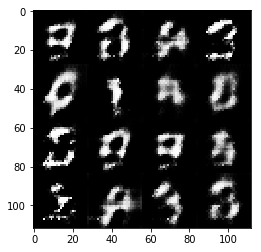

Epoch 0/2... Discriminator Loss: 0.5774... Generator Loss: 1.4708
Epoch 0/2... Discriminator Loss: 0.7240... Generator Loss: 1.2625
Epoch 0/2... Discriminator Loss: 0.6078... Generator Loss: 1.5054
Epoch 0/2... Discriminator Loss: 0.6280... Generator Loss: 1.7390
Epoch 0/2... Discriminator Loss: 0.5693... Generator Loss: 2.2347


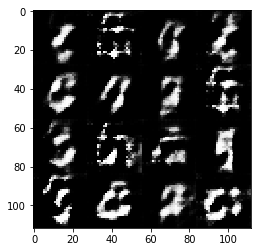

Epoch 0/2... Discriminator Loss: 1.2034... Generator Loss: 0.6665
Epoch 0/2... Discriminator Loss: 0.7668... Generator Loss: 1.5940
Epoch 0/2... Discriminator Loss: 0.5986... Generator Loss: 1.9450
Epoch 0/2... Discriminator Loss: 0.7711... Generator Loss: 2.3673
Epoch 0/2... Discriminator Loss: 1.2669... Generator Loss: 2.2370


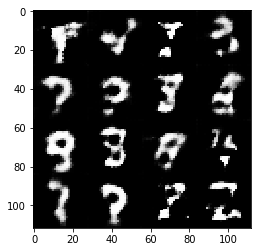

Epoch 0/2... Discriminator Loss: 0.7255... Generator Loss: 1.1980
Epoch 0/2... Discriminator Loss: 0.8624... Generator Loss: 1.0475
Epoch 0/2... Discriminator Loss: 0.8827... Generator Loss: 1.1660
Epoch 0/2... Discriminator Loss: 0.7418... Generator Loss: 1.5544
Epoch 0/2... Discriminator Loss: 0.7495... Generator Loss: 1.2152


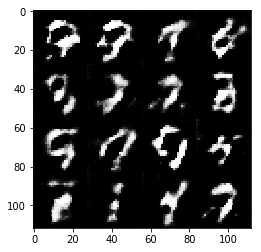

Epoch 0/2... Discriminator Loss: 0.6125... Generator Loss: 2.2110
Epoch 0/2... Discriminator Loss: 0.8896... Generator Loss: 0.9393
Epoch 0/2... Discriminator Loss: 0.8262... Generator Loss: 1.3164
Epoch 0/2... Discriminator Loss: 0.9066... Generator Loss: 1.0017
Epoch 0/2... Discriminator Loss: 0.9213... Generator Loss: 1.1914


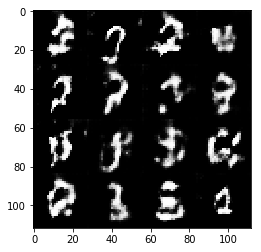

Epoch 0/2... Discriminator Loss: 0.9179... Generator Loss: 1.1487
Epoch 0/2... Discriminator Loss: 0.8903... Generator Loss: 1.4460
Epoch 0/2... Discriminator Loss: 0.9482... Generator Loss: 1.0085
Epoch 0/2... Discriminator Loss: 0.7151... Generator Loss: 1.4142
Epoch 0/2... Discriminator Loss: 0.9587... Generator Loss: 1.0032


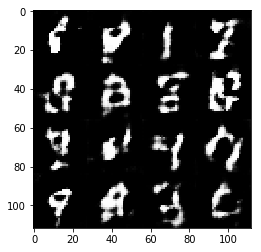

Epoch 0/2... Discriminator Loss: 0.9763... Generator Loss: 1.1490
Epoch 0/2... Discriminator Loss: 1.0170... Generator Loss: 1.4320
Epoch 0/2... Discriminator Loss: 0.7290... Generator Loss: 1.4759
Epoch 0/2... Discriminator Loss: 1.0589... Generator Loss: 1.5327
Epoch 0/2... Discriminator Loss: 1.1132... Generator Loss: 0.8049


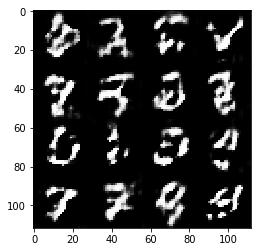

Epoch 0/2... Discriminator Loss: 1.2392... Generator Loss: 0.8266
Epoch 0/2... Discriminator Loss: 0.9591... Generator Loss: 1.1685
Epoch 0/2... Discriminator Loss: 1.0537... Generator Loss: 1.6928
Epoch 0/2... Discriminator Loss: 1.1029... Generator Loss: 0.8218
Epoch 0/2... Discriminator Loss: 0.9598... Generator Loss: 0.8780


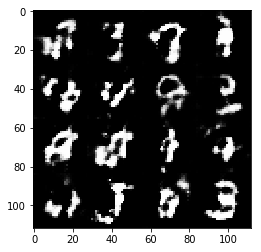

Epoch 0/2... Discriminator Loss: 0.9218... Generator Loss: 1.4159
Epoch 0/2... Discriminator Loss: 1.0498... Generator Loss: 1.3329
Epoch 0/2... Discriminator Loss: 1.2391... Generator Loss: 0.6334
Epoch 0/2... Discriminator Loss: 0.9788... Generator Loss: 1.3618
Epoch 0/2... Discriminator Loss: 0.9641... Generator Loss: 1.3055


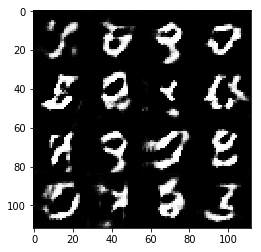

Epoch 0/2... Discriminator Loss: 1.0691... Generator Loss: 1.5863
Epoch 0/2... Discriminator Loss: 1.1082... Generator Loss: 1.6699
Epoch 0/2... Discriminator Loss: 1.1426... Generator Loss: 1.1627
Epoch 0/2... Discriminator Loss: 0.9835... Generator Loss: 1.1000
Epoch 0/2... Discriminator Loss: 1.0386... Generator Loss: 1.0568


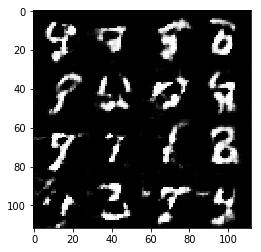

Epoch 0/2... Discriminator Loss: 0.9413... Generator Loss: 0.9675
Epoch 0/2... Discriminator Loss: 0.9575... Generator Loss: 0.8259
Epoch 0/2... Discriminator Loss: 0.8460... Generator Loss: 1.3396
Epoch 1/2... Discriminator Loss: 1.1037... Generator Loss: 1.1605
Epoch 1/2... Discriminator Loss: 0.8971... Generator Loss: 1.0927


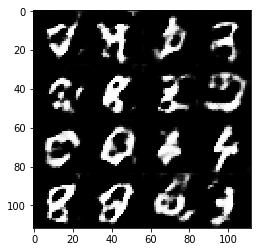

Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 2.1350
Epoch 1/2... Discriminator Loss: 1.2401... Generator Loss: 0.6060
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 1.0836... Generator Loss: 1.3643
Epoch 1/2... Discriminator Loss: 1.0908... Generator Loss: 0.9016


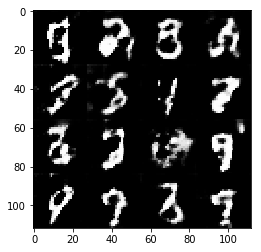

Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 0.8149
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 1.0017
Epoch 1/2... Discriminator Loss: 0.9421... Generator Loss: 0.9927
Epoch 1/2... Discriminator Loss: 0.8717... Generator Loss: 1.1493
Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 0.6718


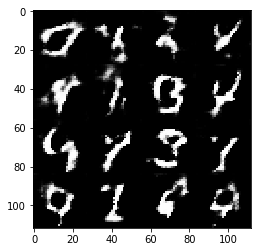

Epoch 1/2... Discriminator Loss: 0.9237... Generator Loss: 1.0112
Epoch 1/2... Discriminator Loss: 1.0909... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 0.6747
Epoch 1/2... Discriminator Loss: 0.9936... Generator Loss: 1.0155
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 1.2835


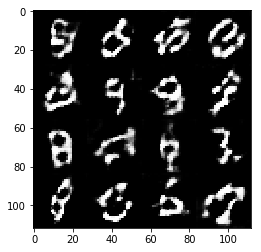

Epoch 1/2... Discriminator Loss: 1.0380... Generator Loss: 1.1795
Epoch 1/2... Discriminator Loss: 1.2570... Generator Loss: 0.7459
Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 0.8582
Epoch 1/2... Discriminator Loss: 0.9935... Generator Loss: 1.1768
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 1.0651


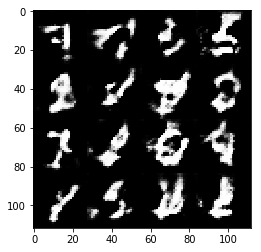

Epoch 1/2... Discriminator Loss: 0.9140... Generator Loss: 1.2063
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 1.0078... Generator Loss: 1.0521
Epoch 1/2... Discriminator Loss: 1.0216... Generator Loss: 0.8933
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 1.1069


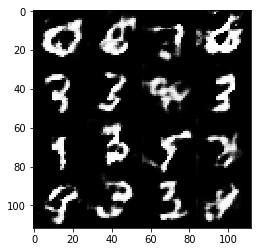

Epoch 1/2... Discriminator Loss: 1.2648... Generator Loss: 0.7209
Epoch 1/2... Discriminator Loss: 1.0297... Generator Loss: 1.0490
Epoch 1/2... Discriminator Loss: 1.3347... Generator Loss: 0.6420
Epoch 1/2... Discriminator Loss: 1.2090... Generator Loss: 0.8010
Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 1.1313


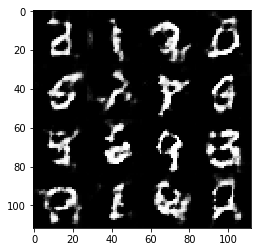

Epoch 1/2... Discriminator Loss: 1.2116... Generator Loss: 1.0927
Epoch 1/2... Discriminator Loss: 1.0321... Generator Loss: 1.0034
Epoch 1/2... Discriminator Loss: 1.0799... Generator Loss: 1.0612
Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 0.8372
Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 1.1354


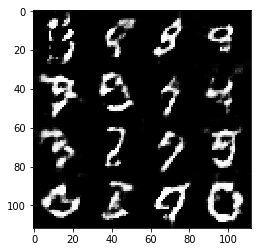

Epoch 1/2... Discriminator Loss: 0.9924... Generator Loss: 0.9540
Epoch 1/2... Discriminator Loss: 1.0759... Generator Loss: 1.2042
Epoch 1/2... Discriminator Loss: 1.1101... Generator Loss: 1.3905
Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 0.8490
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 1.1155


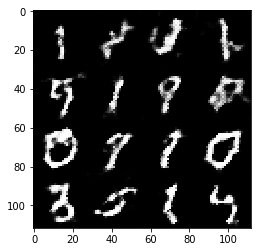

Epoch 1/2... Discriminator Loss: 1.2610... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 1.1287
Epoch 1/2... Discriminator Loss: 0.9600... Generator Loss: 1.2964
Epoch 1/2... Discriminator Loss: 1.1464... Generator Loss: 1.0755
Epoch 1/2... Discriminator Loss: 1.1696... Generator Loss: 0.9401


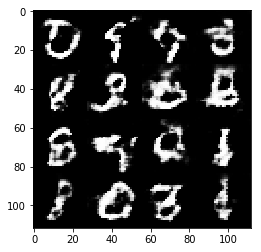

Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 1.0820
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.8479
Epoch 1/2... Discriminator Loss: 1.0333... Generator Loss: 1.0107
Epoch 1/2... Discriminator Loss: 1.1001... Generator Loss: 0.7544
Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 1.0559


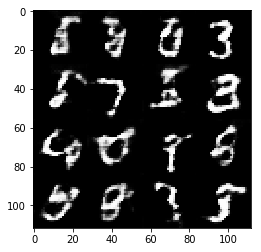

Epoch 1/2... Discriminator Loss: 0.9610... Generator Loss: 0.9083
Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 0.7763
Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 1.0791
Epoch 1/2... Discriminator Loss: 1.0864... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 1.1272... Generator Loss: 0.9588


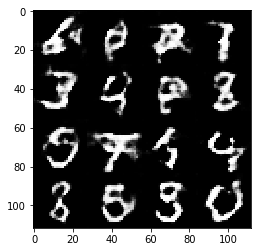

Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 0.7098
Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 1.0672
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 1.2811
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 1.3202


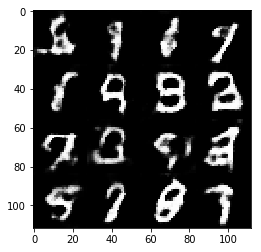

Epoch 1/2... Discriminator Loss: 1.1300... Generator Loss: 0.8157
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 0.8745
Epoch 1/2... Discriminator Loss: 1.0135... Generator Loss: 1.0772
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.9531
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 0.6942


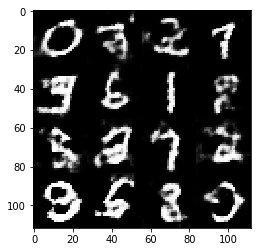

Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 1.0488
Epoch 1/2... Discriminator Loss: 1.2911... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 1.0312... Generator Loss: 0.9634
Epoch 1/2... Discriminator Loss: 1.2932... Generator Loss: 0.7078
Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 0.6163


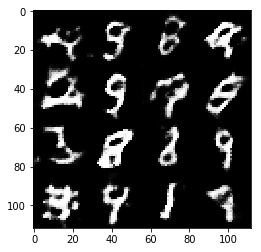

Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 1.3532
Epoch 1/2... Discriminator Loss: 1.1732... Generator Loss: 0.9421
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 1.0386
Epoch 1/2... Discriminator Loss: 1.1528... Generator Loss: 0.9280
Epoch 1/2... Discriminator Loss: 1.0170... Generator Loss: 0.9912


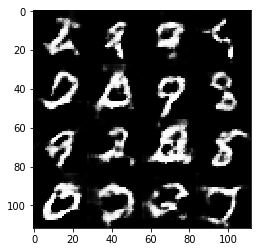

Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 1.1465
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 0.8434
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 0.9840
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 1.0312
Epoch 1/2... Discriminator Loss: 1.0901... Generator Loss: 0.8705


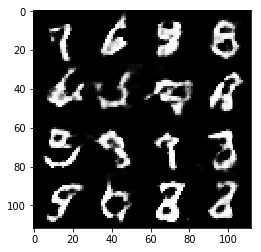

Epoch 1/2... Discriminator Loss: 1.3048... Generator Loss: 0.6840
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 0.8905
Epoch 1/2... Discriminator Loss: 1.1568... Generator Loss: 0.8159
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 1.0375
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 0.9812


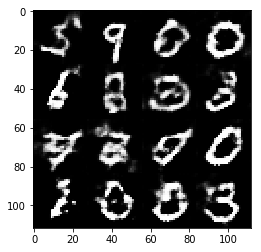

Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.9860
Epoch 1/2... Discriminator Loss: 1.2173... Generator Loss: 0.9315
Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 0.8405
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 1.1564
Epoch 1/2... Discriminator Loss: 1.1503... Generator Loss: 1.0506


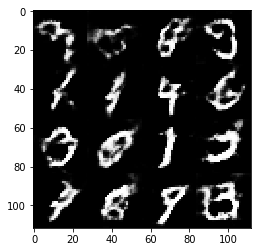

Epoch 1/2... Discriminator Loss: 1.2017... Generator Loss: 0.9671
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.7876


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.4451... Generator Loss: 0.3400
Epoch 0/1... Discriminator Loss: 0.0543... Generator Loss: 4.6195
Epoch 0/1... Discriminator Loss: 0.2276... Generator Loss: 1.8769
Epoch 0/1... Discriminator Loss: 0.1280... Generator Loss: 2.6526
Epoch 0/1... Discriminator Loss: 0.1464... Generator Loss: 2.6791


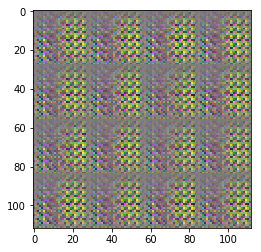

Epoch 0/1... Discriminator Loss: 0.1305... Generator Loss: 2.2863
Epoch 0/1... Discriminator Loss: 0.0824... Generator Loss: 3.0689
Epoch 0/1... Discriminator Loss: 0.0623... Generator Loss: 3.2829
Epoch 0/1... Discriminator Loss: 0.0559... Generator Loss: 3.5501
Epoch 0/1... Discriminator Loss: 0.0575... Generator Loss: 3.3523


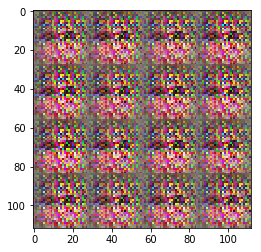

Epoch 0/1... Discriminator Loss: 0.0921... Generator Loss: 3.2217
Epoch 0/1... Discriminator Loss: 0.1007... Generator Loss: 3.0259
Epoch 0/1... Discriminator Loss: 0.0636... Generator Loss: 3.2862
Epoch 0/1... Discriminator Loss: 0.1250... Generator Loss: 2.5797
Epoch 0/1... Discriminator Loss: 0.1452... Generator Loss: 2.4813


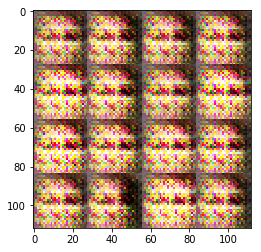

Epoch 0/1... Discriminator Loss: 0.4335... Generator Loss: 2.2374
Epoch 0/1... Discriminator Loss: 0.7519... Generator Loss: 0.8336
Epoch 0/1... Discriminator Loss: 0.2329... Generator Loss: 2.1217
Epoch 0/1... Discriminator Loss: 0.3907... Generator Loss: 3.3302
Epoch 0/1... Discriminator Loss: 0.5092... Generator Loss: 1.3383


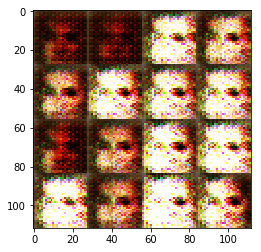

Epoch 0/1... Discriminator Loss: 0.4058... Generator Loss: 4.7733
Epoch 0/1... Discriminator Loss: 0.1932... Generator Loss: 3.8710
Epoch 0/1... Discriminator Loss: 0.2923... Generator Loss: 1.9809
Epoch 0/1... Discriminator Loss: 0.5299... Generator Loss: 1.0219
Epoch 0/1... Discriminator Loss: 0.1242... Generator Loss: 2.6765


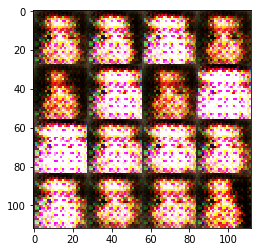

Epoch 0/1... Discriminator Loss: 0.2037... Generator Loss: 2.4669
Epoch 0/1... Discriminator Loss: 0.1535... Generator Loss: 2.9600
Epoch 0/1... Discriminator Loss: 0.1544... Generator Loss: 2.5991
Epoch 0/1... Discriminator Loss: 0.1357... Generator Loss: 2.6511
Epoch 0/1... Discriminator Loss: 0.1675... Generator Loss: 2.3395


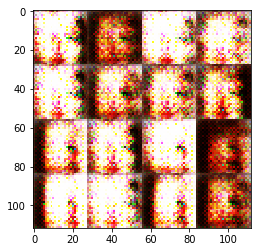

Epoch 0/1... Discriminator Loss: 0.1338... Generator Loss: 3.0035
Epoch 0/1... Discriminator Loss: 0.1351... Generator Loss: 2.8737
Epoch 0/1... Discriminator Loss: 0.8230... Generator Loss: 8.0571
Epoch 0/1... Discriminator Loss: 0.1790... Generator Loss: 2.6086
Epoch 0/1... Discriminator Loss: 0.2039... Generator Loss: 1.9884


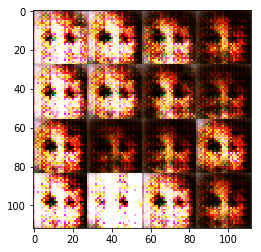

Epoch 0/1... Discriminator Loss: 0.2646... Generator Loss: 1.7232
Epoch 0/1... Discriminator Loss: 0.1196... Generator Loss: 2.6371
Epoch 0/1... Discriminator Loss: 0.1346... Generator Loss: 2.7611
Epoch 0/1... Discriminator Loss: 0.1426... Generator Loss: 2.3203
Epoch 0/1... Discriminator Loss: 0.1267... Generator Loss: 2.4546


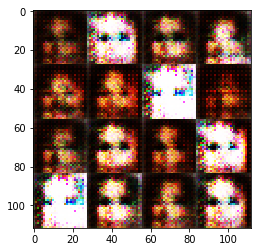

Epoch 0/1... Discriminator Loss: 1.3948... Generator Loss: 11.9384
Epoch 0/1... Discriminator Loss: 0.2188... Generator Loss: 2.1044
Epoch 0/1... Discriminator Loss: 0.0925... Generator Loss: 3.2324
Epoch 0/1... Discriminator Loss: 1.0522... Generator Loss: 0.6322
Epoch 0/1... Discriminator Loss: 0.1236... Generator Loss: 8.4757


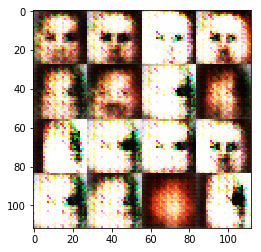

Epoch 0/1... Discriminator Loss: 0.3028... Generator Loss: 1.8016
Epoch 0/1... Discriminator Loss: 0.1463... Generator Loss: 3.0836
Epoch 0/1... Discriminator Loss: 0.2280... Generator Loss: 2.8067
Epoch 0/1... Discriminator Loss: 0.1518... Generator Loss: 3.1930
Epoch 0/1... Discriminator Loss: 0.2399... Generator Loss: 2.2167


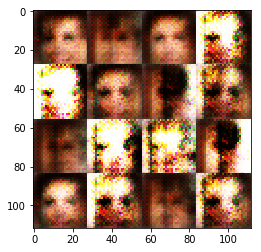

Epoch 0/1... Discriminator Loss: 1.2939... Generator Loss: 0.4822
Epoch 0/1... Discriminator Loss: 0.6209... Generator Loss: 6.1468
Epoch 0/1... Discriminator Loss: 0.4346... Generator Loss: 2.9399
Epoch 0/1... Discriminator Loss: 1.0856... Generator Loss: 0.5160
Epoch 0/1... Discriminator Loss: 0.1744... Generator Loss: 2.6329


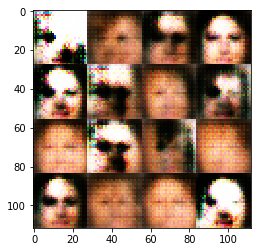

Epoch 0/1... Discriminator Loss: 1.4139... Generator Loss: 3.7982
Epoch 0/1... Discriminator Loss: 0.5193... Generator Loss: 1.6208
Epoch 0/1... Discriminator Loss: 0.7666... Generator Loss: 0.9195
Epoch 0/1... Discriminator Loss: 0.2911... Generator Loss: 2.1694
Epoch 0/1... Discriminator Loss: 0.1940... Generator Loss: 3.3001


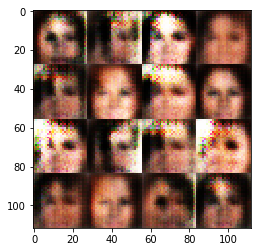

Epoch 0/1... Discriminator Loss: 0.4581... Generator Loss: 1.3413
Epoch 0/1... Discriminator Loss: 0.1127... Generator Loss: 4.4782
Epoch 0/1... Discriminator Loss: 1.0638... Generator Loss: 4.1632
Epoch 0/1... Discriminator Loss: 0.4123... Generator Loss: 1.6202
Epoch 0/1... Discriminator Loss: 0.2500... Generator Loss: 2.7130


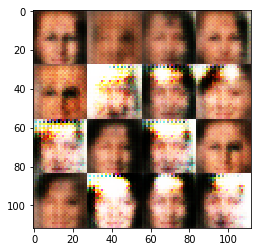

Epoch 0/1... Discriminator Loss: 0.3027... Generator Loss: 4.0769
Epoch 0/1... Discriminator Loss: 0.4421... Generator Loss: 3.3472
Epoch 0/1... Discriminator Loss: 0.4476... Generator Loss: 3.6915
Epoch 0/1... Discriminator Loss: 0.4967... Generator Loss: 1.3111
Epoch 0/1... Discriminator Loss: 0.1532... Generator Loss: 3.7555


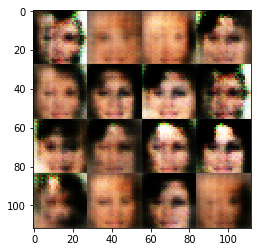

Epoch 0/1... Discriminator Loss: 0.2682... Generator Loss: 2.8720
Epoch 0/1... Discriminator Loss: 0.2077... Generator Loss: 3.9404
Epoch 0/1... Discriminator Loss: 0.5636... Generator Loss: 1.1589
Epoch 0/1... Discriminator Loss: 0.4824... Generator Loss: 1.3026
Epoch 0/1... Discriminator Loss: 0.2431... Generator Loss: 2.4085


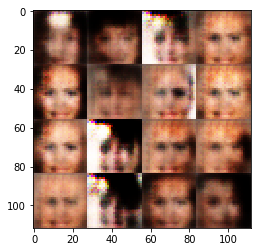

Epoch 0/1... Discriminator Loss: 0.2710... Generator Loss: 2.4716
Epoch 0/1... Discriminator Loss: 0.1844... Generator Loss: 3.1744
Epoch 0/1... Discriminator Loss: 0.2868... Generator Loss: 2.0746
Epoch 0/1... Discriminator Loss: 0.7010... Generator Loss: 3.6832
Epoch 0/1... Discriminator Loss: 0.2827... Generator Loss: 3.7430


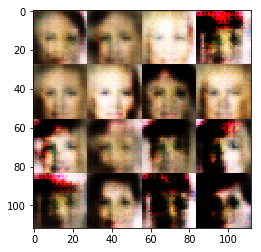

Epoch 0/1... Discriminator Loss: 0.5417... Generator Loss: 1.5260
Epoch 0/1... Discriminator Loss: 0.3433... Generator Loss: 1.8919
Epoch 0/1... Discriminator Loss: 2.8940... Generator Loss: 6.2878
Epoch 0/1... Discriminator Loss: 1.2104... Generator Loss: 0.6179
Epoch 0/1... Discriminator Loss: 0.5542... Generator Loss: 1.5626


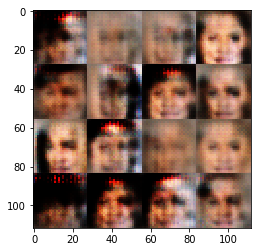

Epoch 0/1... Discriminator Loss: 0.7048... Generator Loss: 2.2170
Epoch 0/1... Discriminator Loss: 0.2906... Generator Loss: 2.1922
Epoch 0/1... Discriminator Loss: 0.6018... Generator Loss: 1.3013
Epoch 0/1... Discriminator Loss: 0.4681... Generator Loss: 1.5487
Epoch 0/1... Discriminator Loss: 1.0627... Generator Loss: 4.4318


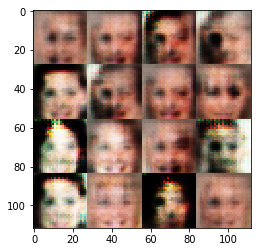

Epoch 0/1... Discriminator Loss: 0.4185... Generator Loss: 1.9930
Epoch 0/1... Discriminator Loss: 0.3143... Generator Loss: 2.4068
Epoch 0/1... Discriminator Loss: 0.5569... Generator Loss: 1.6400
Epoch 0/1... Discriminator Loss: 0.4538... Generator Loss: 1.5207
Epoch 0/1... Discriminator Loss: 0.8717... Generator Loss: 0.7101


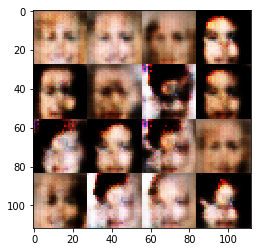

Epoch 0/1... Discriminator Loss: 0.3707... Generator Loss: 1.8628
Epoch 0/1... Discriminator Loss: 0.2055... Generator Loss: 2.7350
Epoch 0/1... Discriminator Loss: 0.5169... Generator Loss: 3.9524
Epoch 0/1... Discriminator Loss: 1.3531... Generator Loss: 4.1888
Epoch 0/1... Discriminator Loss: 1.0744... Generator Loss: 4.6676


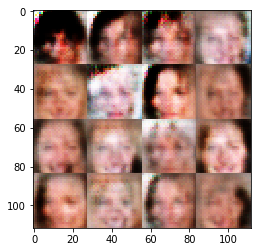

Epoch 0/1... Discriminator Loss: 0.3631... Generator Loss: 2.2563
Epoch 0/1... Discriminator Loss: 0.3176... Generator Loss: 5.0237
Epoch 0/1... Discriminator Loss: 0.2771... Generator Loss: 2.5209
Epoch 0/1... Discriminator Loss: 0.2001... Generator Loss: 3.2846
Epoch 0/1... Discriminator Loss: 0.3468... Generator Loss: 2.5766


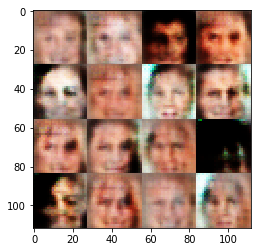

Epoch 0/1... Discriminator Loss: 0.4595... Generator Loss: 1.5364
Epoch 0/1... Discriminator Loss: 0.5895... Generator Loss: 1.5204
Epoch 0/1... Discriminator Loss: 0.5745... Generator Loss: 1.6303
Epoch 0/1... Discriminator Loss: 4.0527... Generator Loss: 7.4491
Epoch 0/1... Discriminator Loss: 0.3791... Generator Loss: 2.0444


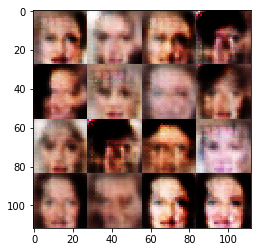

Epoch 0/1... Discriminator Loss: 0.4556... Generator Loss: 1.7769
Epoch 0/1... Discriminator Loss: 0.3631... Generator Loss: 2.1824
Epoch 0/1... Discriminator Loss: 0.4120... Generator Loss: 1.5766
Epoch 0/1... Discriminator Loss: 0.3224... Generator Loss: 2.0607
Epoch 0/1... Discriminator Loss: 0.4307... Generator Loss: 1.8004


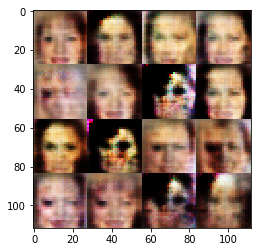

Epoch 0/1... Discriminator Loss: 0.3219... Generator Loss: 1.9918
Epoch 0/1... Discriminator Loss: 0.3123... Generator Loss: 2.0757
Epoch 0/1... Discriminator Loss: 0.4212... Generator Loss: 4.7747
Epoch 0/1... Discriminator Loss: 0.9866... Generator Loss: 0.6250
Epoch 0/1... Discriminator Loss: 0.5221... Generator Loss: 1.3349


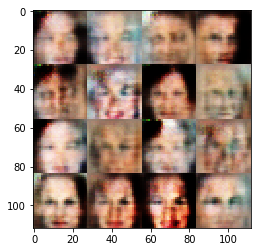

Epoch 0/1... Discriminator Loss: 0.6227... Generator Loss: 1.2281
Epoch 0/1... Discriminator Loss: 1.5470... Generator Loss: 0.5340
Epoch 0/1... Discriminator Loss: 1.6492... Generator Loss: 0.4357
Epoch 0/1... Discriminator Loss: 0.6792... Generator Loss: 1.2373
Epoch 0/1... Discriminator Loss: 0.5003... Generator Loss: 1.5221


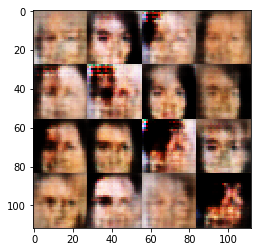

Epoch 0/1... Discriminator Loss: 0.5501... Generator Loss: 1.2183
Epoch 0/1... Discriminator Loss: 0.3216... Generator Loss: 1.8916
Epoch 0/1... Discriminator Loss: 0.3919... Generator Loss: 1.6355
Epoch 0/1... Discriminator Loss: 0.6511... Generator Loss: 0.9921
Epoch 0/1... Discriminator Loss: 0.3241... Generator Loss: 2.6615


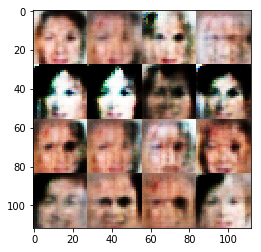

Epoch 0/1... Discriminator Loss: 0.3819... Generator Loss: 2.6437
Epoch 0/1... Discriminator Loss: 0.4417... Generator Loss: 2.3049
Epoch 0/1... Discriminator Loss: 0.3889... Generator Loss: 3.2668
Epoch 0/1... Discriminator Loss: 0.3276... Generator Loss: 3.9080
Epoch 0/1... Discriminator Loss: 0.4440... Generator Loss: 1.5753


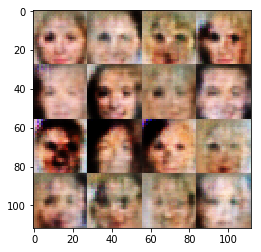

Epoch 0/1... Discriminator Loss: 0.3019... Generator Loss: 1.9678
Epoch 0/1... Discriminator Loss: 0.2414... Generator Loss: 2.2037
Epoch 0/1... Discriminator Loss: 0.4215... Generator Loss: 1.6119
Epoch 0/1... Discriminator Loss: 0.2958... Generator Loss: 2.3116
Epoch 0/1... Discriminator Loss: 0.1412... Generator Loss: 4.0153


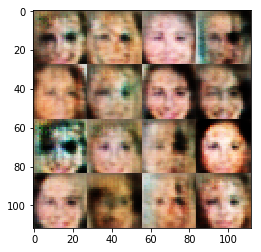

Epoch 0/1... Discriminator Loss: 0.1735... Generator Loss: 3.2029
Epoch 0/1... Discriminator Loss: 3.4981... Generator Loss: 7.7267
Epoch 0/1... Discriminator Loss: 0.7071... Generator Loss: 1.2534
Epoch 0/1... Discriminator Loss: 0.3820... Generator Loss: 2.7427
Epoch 0/1... Discriminator Loss: 0.5764... Generator Loss: 2.2947


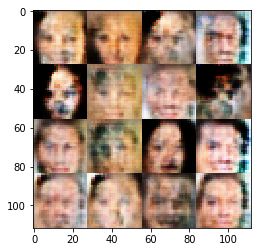

Epoch 0/1... Discriminator Loss: 0.4321... Generator Loss: 2.0846
Epoch 0/1... Discriminator Loss: 0.4135... Generator Loss: 1.9023
Epoch 0/1... Discriminator Loss: 0.5993... Generator Loss: 2.6320
Epoch 0/1... Discriminator Loss: 0.4304... Generator Loss: 1.6754
Epoch 0/1... Discriminator Loss: 0.2176... Generator Loss: 2.4683


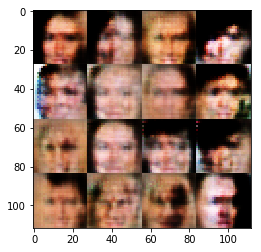

Epoch 0/1... Discriminator Loss: 0.5543... Generator Loss: 1.2305
Epoch 0/1... Discriminator Loss: 0.2773... Generator Loss: 2.2092
Epoch 0/1... Discriminator Loss: 0.8195... Generator Loss: 2.9207
Epoch 0/1... Discriminator Loss: 0.3195... Generator Loss: 3.2659
Epoch 0/1... Discriminator Loss: 0.2694... Generator Loss: 2.9062


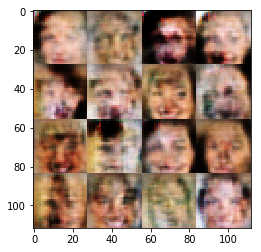

Epoch 0/1... Discriminator Loss: 0.2222... Generator Loss: 2.3140
Epoch 0/1... Discriminator Loss: 0.4405... Generator Loss: 2.0041
Epoch 0/1... Discriminator Loss: 0.5300... Generator Loss: 1.4199
Epoch 0/1... Discriminator Loss: 0.2775... Generator Loss: 2.0556
Epoch 0/1... Discriminator Loss: 0.5682... Generator Loss: 1.4056


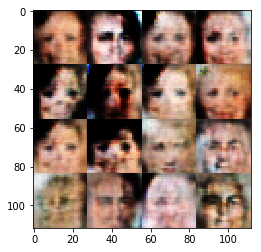

Epoch 0/1... Discriminator Loss: 0.4471... Generator Loss: 1.4767
Epoch 0/1... Discriminator Loss: 0.4020... Generator Loss: 1.4493
Epoch 0/1... Discriminator Loss: 0.4244... Generator Loss: 1.3975
Epoch 0/1... Discriminator Loss: 0.4656... Generator Loss: 1.8795
Epoch 0/1... Discriminator Loss: 0.1805... Generator Loss: 3.5746


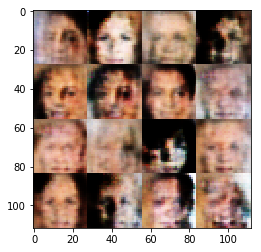

Epoch 0/1... Discriminator Loss: 0.1840... Generator Loss: 3.6043
Epoch 0/1... Discriminator Loss: 0.2108... Generator Loss: 2.9913
Epoch 0/1... Discriminator Loss: 0.6834... Generator Loss: 1.1077
Epoch 0/1... Discriminator Loss: 0.2167... Generator Loss: 2.7953
Epoch 0/1... Discriminator Loss: 0.6512... Generator Loss: 4.4605


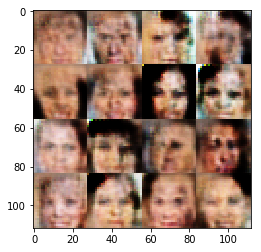

Epoch 0/1... Discriminator Loss: 0.4893... Generator Loss: 1.5223
Epoch 0/1... Discriminator Loss: 0.5676... Generator Loss: 1.3981
Epoch 0/1... Discriminator Loss: 0.3124... Generator Loss: 1.8725
Epoch 0/1... Discriminator Loss: 0.1639... Generator Loss: 3.0302
Epoch 0/1... Discriminator Loss: 0.3371... Generator Loss: 2.1643


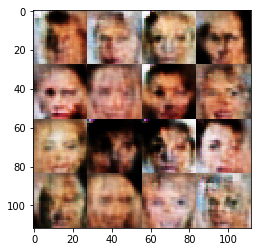

Epoch 0/1... Discriminator Loss: 0.3519... Generator Loss: 2.1191
Epoch 0/1... Discriminator Loss: 0.3143... Generator Loss: 1.8233
Epoch 0/1... Discriminator Loss: 0.4952... Generator Loss: 2.5376
Epoch 0/1... Discriminator Loss: 0.2486... Generator Loss: 2.6733
Epoch 0/1... Discriminator Loss: 0.2206... Generator Loss: 2.4597


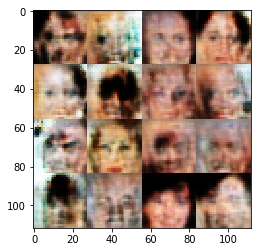

Epoch 0/1... Discriminator Loss: 0.1958... Generator Loss: 3.0650
Epoch 0/1... Discriminator Loss: 0.4146... Generator Loss: 3.8743
Epoch 0/1... Discriminator Loss: 3.3211... Generator Loss: 5.8255
Epoch 0/1... Discriminator Loss: 0.5759... Generator Loss: 1.7649
Epoch 0/1... Discriminator Loss: 0.3327... Generator Loss: 2.1519


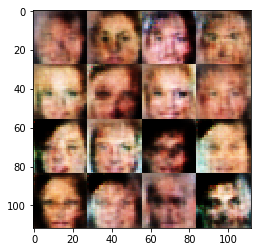

Epoch 0/1... Discriminator Loss: 0.1744... Generator Loss: 5.2033
Epoch 0/1... Discriminator Loss: 0.2452... Generator Loss: 3.3929
Epoch 0/1... Discriminator Loss: 0.3762... Generator Loss: 1.6939
Epoch 0/1... Discriminator Loss: 0.4109... Generator Loss: 1.8164
Epoch 0/1... Discriminator Loss: 0.2973... Generator Loss: 2.3379


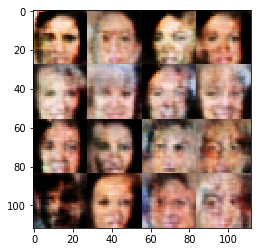

Epoch 0/1... Discriminator Loss: 0.9350... Generator Loss: 0.7327
Epoch 0/1... Discriminator Loss: 0.5764... Generator Loss: 1.4067
Epoch 0/1... Discriminator Loss: 0.4510... Generator Loss: 1.6491
Epoch 0/1... Discriminator Loss: 0.2388... Generator Loss: 2.4116
Epoch 0/1... Discriminator Loss: 0.4027... Generator Loss: 1.5078


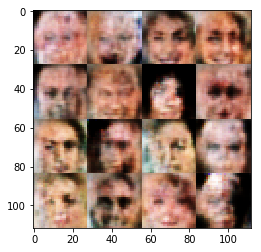

Epoch 0/1... Discriminator Loss: 0.5022... Generator Loss: 3.8450
Epoch 0/1... Discriminator Loss: 0.5362... Generator Loss: 1.3360
Epoch 0/1... Discriminator Loss: 0.2715... Generator Loss: 2.9897
Epoch 0/1... Discriminator Loss: 0.5557... Generator Loss: 1.2983
Epoch 0/1... Discriminator Loss: 0.1783... Generator Loss: 3.0553


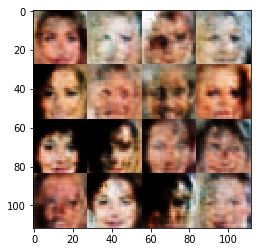

Epoch 0/1... Discriminator Loss: 0.1332... Generator Loss: 3.5183
Epoch 0/1... Discriminator Loss: 0.5664... Generator Loss: 1.7095
Epoch 0/1... Discriminator Loss: 0.7605... Generator Loss: 2.9777
Epoch 0/1... Discriminator Loss: 1.1948... Generator Loss: 0.5611
Epoch 0/1... Discriminator Loss: 0.2545... Generator Loss: 2.5385


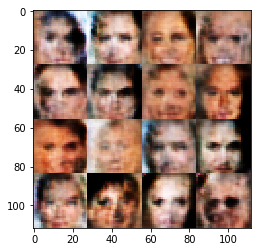

Epoch 0/1... Discriminator Loss: 0.4144... Generator Loss: 1.7193
Epoch 0/1... Discriminator Loss: 0.4068... Generator Loss: 1.7818
Epoch 0/1... Discriminator Loss: 0.2958... Generator Loss: 2.5251
Epoch 0/1... Discriminator Loss: 0.3079... Generator Loss: 3.4268
Epoch 0/1... Discriminator Loss: 0.8366... Generator Loss: 1.9966


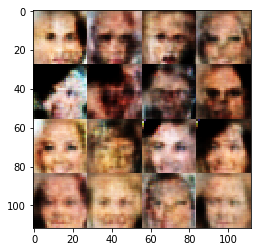

Epoch 0/1... Discriminator Loss: 1.3342... Generator Loss: 0.5164
Epoch 0/1... Discriminator Loss: 0.4492... Generator Loss: 2.2217
Epoch 0/1... Discriminator Loss: 0.6400... Generator Loss: 1.2831
Epoch 0/1... Discriminator Loss: 0.5754... Generator Loss: 1.5850
Epoch 0/1... Discriminator Loss: 0.3050... Generator Loss: 2.3676


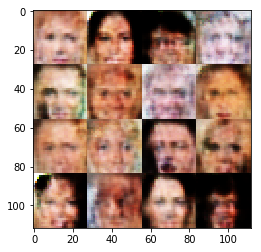

Epoch 0/1... Discriminator Loss: 0.6574... Generator Loss: 1.1359
Epoch 0/1... Discriminator Loss: 1.3153... Generator Loss: 0.5156
Epoch 0/1... Discriminator Loss: 0.6522... Generator Loss: 1.1619
Epoch 0/1... Discriminator Loss: 1.8923... Generator Loss: 5.5755
Epoch 0/1... Discriminator Loss: 0.5779... Generator Loss: 1.2398


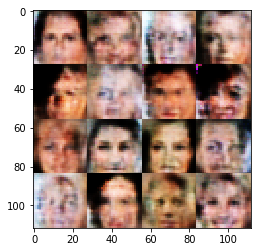

Epoch 0/1... Discriminator Loss: 0.4177... Generator Loss: 2.9729
Epoch 0/1... Discriminator Loss: 0.6040... Generator Loss: 2.0743
Epoch 0/1... Discriminator Loss: 0.3035... Generator Loss: 2.1752
Epoch 0/1... Discriminator Loss: 0.6286... Generator Loss: 2.7790
Epoch 0/1... Discriminator Loss: 0.4370... Generator Loss: 1.5847


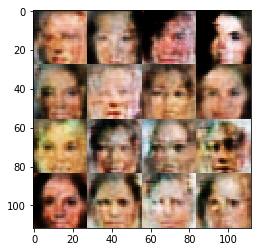

Epoch 0/1... Discriminator Loss: 0.2615... Generator Loss: 2.2750
Epoch 0/1... Discriminator Loss: 0.6052... Generator Loss: 2.0198
Epoch 0/1... Discriminator Loss: 0.3060... Generator Loss: 1.9175
Epoch 0/1... Discriminator Loss: 0.3795... Generator Loss: 2.5948
Epoch 0/1... Discriminator Loss: 0.3637... Generator Loss: 2.7417


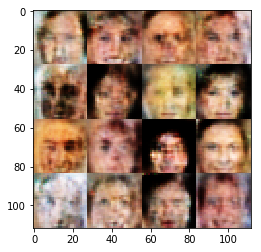

Epoch 0/1... Discriminator Loss: 0.4908... Generator Loss: 2.0930
Epoch 0/1... Discriminator Loss: 0.5209... Generator Loss: 1.3554
Epoch 0/1... Discriminator Loss: 0.4494... Generator Loss: 1.5269
Epoch 0/1... Discriminator Loss: 0.3709... Generator Loss: 2.4665
Epoch 0/1... Discriminator Loss: 0.4513... Generator Loss: 1.9196


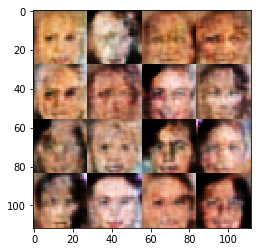

Epoch 0/1... Discriminator Loss: 0.3646... Generator Loss: 2.2668
Epoch 0/1... Discriminator Loss: 0.4897... Generator Loss: 1.3924
Epoch 0/1... Discriminator Loss: 0.2953... Generator Loss: 4.2152
Epoch 0/1... Discriminator Loss: 0.3990... Generator Loss: 3.1730
Epoch 0/1... Discriminator Loss: 0.6080... Generator Loss: 2.1835


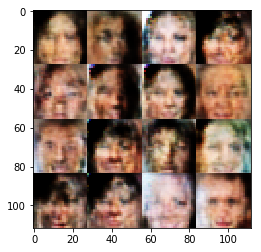

Epoch 0/1... Discriminator Loss: 0.4492... Generator Loss: 1.9195
Epoch 0/1... Discriminator Loss: 0.3418... Generator Loss: 3.0991
Epoch 0/1... Discriminator Loss: 0.1921... Generator Loss: 3.4839
Epoch 0/1... Discriminator Loss: 0.3719... Generator Loss: 1.6272
Epoch 0/1... Discriminator Loss: 0.2296... Generator Loss: 2.8309


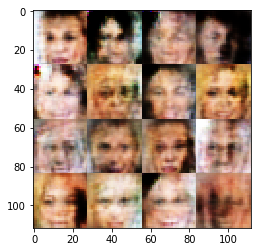

Epoch 0/1... Discriminator Loss: 0.3746... Generator Loss: 2.0257
Epoch 0/1... Discriminator Loss: 0.2917... Generator Loss: 2.0056
Epoch 0/1... Discriminator Loss: 0.4953... Generator Loss: 1.3956
Epoch 0/1... Discriminator Loss: 0.2002... Generator Loss: 3.5792
Epoch 0/1... Discriminator Loss: 0.3979... Generator Loss: 1.5987


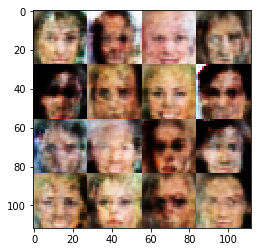

Epoch 0/1... Discriminator Loss: 0.4795... Generator Loss: 1.4242
Epoch 0/1... Discriminator Loss: 0.3222... Generator Loss: 2.4075
Epoch 0/1... Discriminator Loss: 0.3345... Generator Loss: 2.4754
Epoch 0/1... Discriminator Loss: 0.2071... Generator Loss: 4.0471
Epoch 0/1... Discriminator Loss: 0.7369... Generator Loss: 0.9530


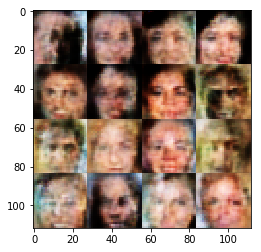

Epoch 0/1... Discriminator Loss: 0.6604... Generator Loss: 2.6027
Epoch 0/1... Discriminator Loss: 1.2857... Generator Loss: 0.5786
Epoch 0/1... Discriminator Loss: 0.4521... Generator Loss: 3.0554
Epoch 0/1... Discriminator Loss: 0.6196... Generator Loss: 1.1869
Epoch 0/1... Discriminator Loss: 0.3729... Generator Loss: 1.9676


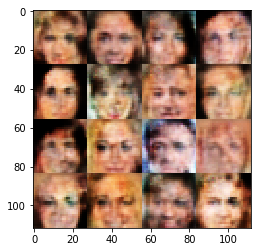

Epoch 0/1... Discriminator Loss: 0.5838... Generator Loss: 2.7775
Epoch 0/1... Discriminator Loss: 0.6209... Generator Loss: 2.5642
Epoch 0/1... Discriminator Loss: 0.8107... Generator Loss: 0.9696
Epoch 0/1... Discriminator Loss: 0.4148... Generator Loss: 1.6362
Epoch 0/1... Discriminator Loss: 1.0663... Generator Loss: 2.9801


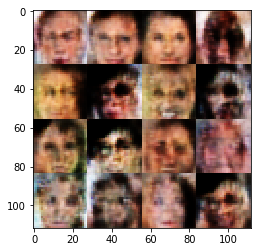

Epoch 0/1... Discriminator Loss: 2.0325... Generator Loss: 0.3223
Epoch 0/1... Discriminator Loss: 0.6973... Generator Loss: 1.0932
Epoch 0/1... Discriminator Loss: 0.2659... Generator Loss: 2.4574
Epoch 0/1... Discriminator Loss: 0.3661... Generator Loss: 2.6014
Epoch 0/1... Discriminator Loss: 0.2012... Generator Loss: 2.4794


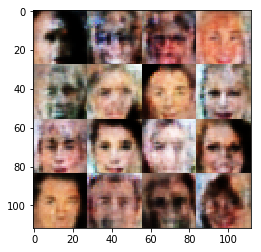

Epoch 0/1... Discriminator Loss: 1.3096... Generator Loss: 0.4722
Epoch 0/1... Discriminator Loss: 0.4732... Generator Loss: 2.4124
Epoch 0/1... Discriminator Loss: 0.7211... Generator Loss: 2.8695
Epoch 0/1... Discriminator Loss: 0.4495... Generator Loss: 1.5946
Epoch 0/1... Discriminator Loss: 0.8369... Generator Loss: 0.9402


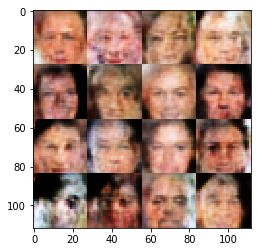

Epoch 0/1... Discriminator Loss: 0.9015... Generator Loss: 4.7903
Epoch 0/1... Discriminator Loss: 0.6608... Generator Loss: 4.2191
Epoch 0/1... Discriminator Loss: 0.3033... Generator Loss: 3.5047
Epoch 0/1... Discriminator Loss: 0.4623... Generator Loss: 1.6303
Epoch 0/1... Discriminator Loss: 0.2870... Generator Loss: 2.8301


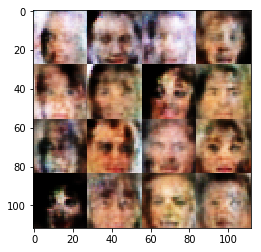

Epoch 0/1... Discriminator Loss: 0.4992... Generator Loss: 1.7109
Epoch 0/1... Discriminator Loss: 0.4641... Generator Loss: 1.9754
Epoch 0/1... Discriminator Loss: 1.6127... Generator Loss: 3.1087
Epoch 0/1... Discriminator Loss: 0.6038... Generator Loss: 2.6247
Epoch 0/1... Discriminator Loss: 0.9590... Generator Loss: 0.8927


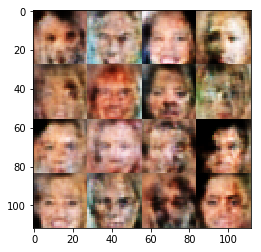

Epoch 0/1... Discriminator Loss: 0.3754... Generator Loss: 1.7054
Epoch 0/1... Discriminator Loss: 0.2741... Generator Loss: 2.4368
Epoch 0/1... Discriminator Loss: 0.7440... Generator Loss: 0.9381
Epoch 0/1... Discriminator Loss: 0.3906... Generator Loss: 2.8874
Epoch 0/1... Discriminator Loss: 0.2967... Generator Loss: 2.2353


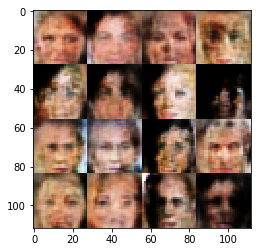

Epoch 0/1... Discriminator Loss: 0.9132... Generator Loss: 0.7764
Epoch 0/1... Discriminator Loss: 0.5735... Generator Loss: 2.8543
Epoch 0/1... Discriminator Loss: 0.2927... Generator Loss: 3.1971
Epoch 0/1... Discriminator Loss: 0.8100... Generator Loss: 3.4107
Epoch 0/1... Discriminator Loss: 0.2698... Generator Loss: 3.6020


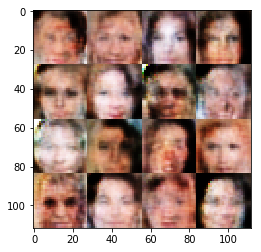

Epoch 0/1... Discriminator Loss: 0.9790... Generator Loss: 0.7686
Epoch 0/1... Discriminator Loss: 0.7386... Generator Loss: 0.9363
Epoch 0/1... Discriminator Loss: 0.8769... Generator Loss: 0.7833
Epoch 0/1... Discriminator Loss: 0.6073... Generator Loss: 1.1874
Epoch 0/1... Discriminator Loss: 1.3462... Generator Loss: 3.0896


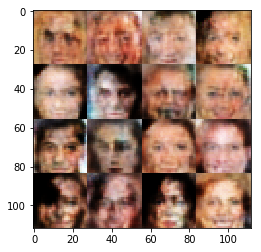

Epoch 0/1... Discriminator Loss: 0.5215... Generator Loss: 2.2878
Epoch 0/1... Discriminator Loss: 0.7219... Generator Loss: 2.6614
Epoch 0/1... Discriminator Loss: 0.5019... Generator Loss: 1.8958
Epoch 0/1... Discriminator Loss: 0.3326... Generator Loss: 2.8323
Epoch 0/1... Discriminator Loss: 0.5083... Generator Loss: 2.3906


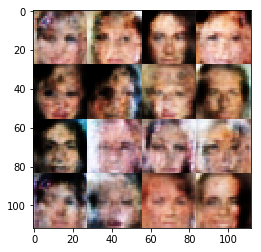

Epoch 0/1... Discriminator Loss: 0.8299... Generator Loss: 0.9684
Epoch 0/1... Discriminator Loss: 0.3739... Generator Loss: 2.4115
Epoch 0/1... Discriminator Loss: 0.3017... Generator Loss: 2.2688
Epoch 0/1... Discriminator Loss: 0.7914... Generator Loss: 2.9129
Epoch 0/1... Discriminator Loss: 0.4708... Generator Loss: 2.6437


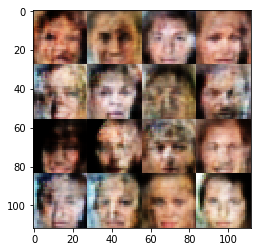

Epoch 0/1... Discriminator Loss: 0.8717... Generator Loss: 0.8736
Epoch 0/1... Discriminator Loss: 0.5611... Generator Loss: 1.9390
Epoch 0/1... Discriminator Loss: 0.5495... Generator Loss: 1.5507
Epoch 0/1... Discriminator Loss: 0.3487... Generator Loss: 2.5314
Epoch 0/1... Discriminator Loss: 0.3749... Generator Loss: 1.7735


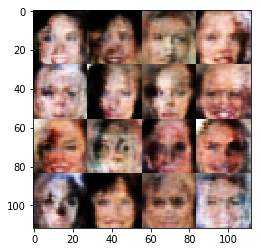

Epoch 0/1... Discriminator Loss: 0.5116... Generator Loss: 1.6009


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.